In [11]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
import datetime

In [12]:
def load():
    train = datasets.MNIST('../TCPAdata/data', train=True, download=True)
    X = train.data.float() / 255
    y = train.targets

    torch.manual_seed(0)
    idx = torch.randperm(len(X))
    X = X[idx]
    y = y[idx]

    X = X.reshape(X.shape[0], -1)
    X = (X - 0.5) / 0.5

    test = datasets.MNIST('../TCPAdata/data', train=False)
    Xt = test.data.float() / 255
    yt = test.targets

    Xt = Xt.reshape(Xt.shape[0], -1)
    Xt = (Xt - 0.5) / 0.5
    return X, y, Xt, yt
X, y, Xt, yt = load()

In [13]:
def plot(subset, savefig=False):
    nsqrt = 10
    fig, axs = plt.subplots(ncols=nsqrt, 
                            nrows=nsqrt,
                            figsize=(10, 10), 
                            gridspec_kw = {'wspace':0.1, 'hspace':0.1})
    np.random.seed(0)
    choice = np.random.choice(len(subset), nsqrt**2)
    for i, ax in enumerate(axs.flatten()):
        plotable = lambda x: x.detach().cpu().numpy().reshape(28, 28)
        ax.imshow(plotable(subset[choice[i]]))
        ax.axis("off")
    if savefig:
        plt.subplots_adjust(left=.01, bottom=.01, right=.99, top=.99)
        plt.savefig(f"img_{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.png", dpi=80)
        plt.close(fig)
plot(X, savefig=True)

In [24]:
import torch
from torch import nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, 
                 ins: int, 
                 hidden: int, 
                 latent: int, 
                 variational: bool):
        super(VAE, self).__init__()
        self.variational = variational
        
        self.enc = nn.Sequential(nn.Linear(ins, hidden), 
                                nn.ReLU(),
                                nn.BatchNorm1d(hidden))
        
        self.mean = nn.Linear(hidden, latent)
        self.log_variance = nn.Linear(hidden, latent)
        
        self.dec = nn.Sequential(nn.Linear(latent, hidden),
                                nn.ReLU(),
                                nn.BatchNorm1d(hidden),
                                nn.Linear(hidden, ins))

    def sample(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        x = self.enc(x)
        mu = self.mean(x)
        log_var = self.log_variance(x)
        z = self.sample(mu, log_var) if self.variational else mu
        x = self.dec(z)
        return x, mu, log_var
    
    def gibbs(self, x0, mask):
        # initalize unobserved (masked out) with random entries
        xn = x0[:]
        xn[mask] = torch.randn(mask.shape)[mask]
        # iterativly predict
        for _ in range(20):
            # reconstruction step
            xn,_,_ = self.forward(xn)
            # reset observed values
            xn[~mask] = x0[~mask]
        return xn
    
vae = VAE(ins=784, hidden=512, latent=64, variational=True)
print(vae)
assert vae(torch.tensor(np.random.randn(20, 784).astype("float32")))

VAE(
  (enc): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mean): Linear(in_features=512, out_features=64, bias=True)
  (log_variance): Linear(in_features=512, out_features=64, bias=True)
  (dec): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [25]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [26]:
def criterion(reconstruction, mu, log_var, original):
    mse = F.mse_loss(reconstruction, original, reduction="sum")
    kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return mse + kl

In [27]:
hist = []
for epoch in range(100):
    vae.train()
    optimizer.zero_grad()
    Xhat, mu, log_var = vae(X)
    loss = criterion(Xhat, mu, log_var, X)
    loss.backward()
    optimizer.step()
    print(epoch, "train loss", loss.item(), end='')
    plot(Xhat, savefig=True)
    
    with torch.no_grad():
        vae.eval()
        Xhat, mu, log_var = vae(Xt)
        loss = criterion(Xhat, mu, log_var, Xt)
    print(" ==> test loss", loss.item())
    
    # early stopping
    hist.append(loss.item())
    if hist[max(epoch-5, 0)] < hist[max(epoch-1, 0)]:
        print("early stopping")
        break

0 train loss 60026376.0 ==> test loss 7684338.5
1 train loss 56324636.0 ==> test loss 7648047.0
2 train loss 53284408.0 ==> test loss 7598439.0
3 train loss 50549916.0 ==> test loss 7541126.0
4 train loss 48299716.0 ==> test loss 7490705.0
5 train loss 46676896.0 ==> test loss 7483896.5
6 train loss 45526872.0 ==> test loss 7523852.0
7 train loss 44648980.0 ==> test loss 7587383.5
8 train loss 43938348.0 ==> test loss 7642586.5
early stopping


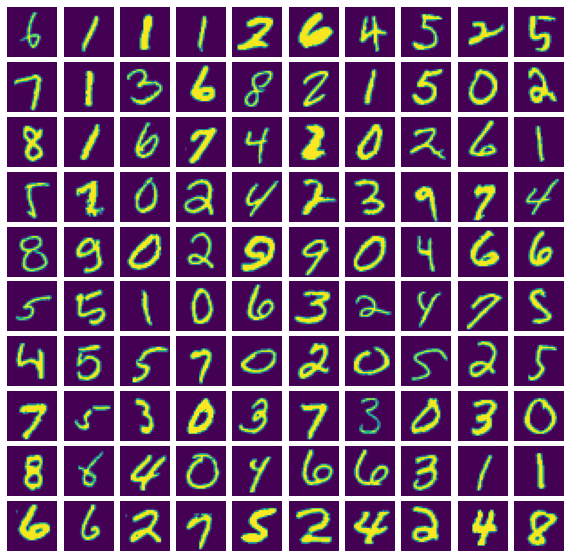

In [18]:
# test inputs
plot(Xt)

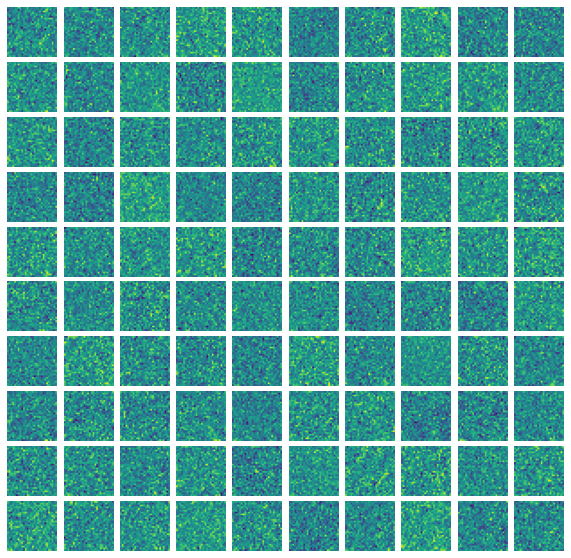

In [19]:
# reconstruction
plot(vae(Xt)[0])

In [20]:
# sample from latent space
plot(vae.dec(torch.randn([25, 2])))

RuntimeError: size mismatch, m1: [25 x 2], m2: [64 x 512] at ../aten/src/TH/generic/THTensorMath.cpp:41

In [ ]:
xy = vae.mean(vae.enc(Xt)).detach().numpy()

In [ ]:
x = xy[:, 0]
y = xy[:, 1]    
c = yt.detach().numpy()

In [ ]:
plt.scatter(x, y, c=c)